In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mp_api.client import MPRester
import pandas as pd

with MPRester("APlevqv7cuLmDnDUlvvoL0sp4cdfDJKP") as mpr:
    docs = mpr.summary.search(
        is_metal = False,
       # elements = ['Mo'],
        band_gap = (0,3),
        fields=['efermi', 'band_gap', 'volume', 'energy_per_atom',
                'total_magnetization','formula_pretty','cbm']
    )

/var/folders/ht/3426pmkd7p3chqxnqsv867h80000gn/T/ipykernel_42067/4109040741.py:10: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  docs = mpr.summary.search(
Retrieving SummaryDoc documents: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61306/61306 [01:38<00:00, 621.28it/s]


In [102]:
efermi, band_gap, volume, energy_per_atom, total_magnetization, equilibrium_reaction_energy_per_atom,cbm,e_total = [], [], [], [], [], [],[],[]
grain_boundaries = []
density = []

nsites = []
for material in docs[:61000]:
    efermi.append(material.efermi)
    band_gap.append(material.band_gap)
    volume.append(material.volume)
    energy_per_atom.append(material.energy_per_atom)
    total_magnetization.append(material.total_magnetization)
    equilibrium_reaction_energy_per_atom.append(material.equilibrium_reaction_energy_per_atom)
    cbm.append(material.cbm)
    e_total.append(material.e_total)
    grain_boundaries.append(material.grain_boundaries)
    density.append(material.density)
    nsites.append(material.nsites)
data = {
    'efermi': efermi,
    'band_gap': band_gap,
    'volume': volume,
    'energy_per_atom': energy_per_atom,  
    'cbm':cbm,
    'density':density,
    'nsites':nsites,
    'total_magnetization':total_magnetization
}

df = pd.DataFrame(data)
df = df.dropna()

In [103]:
df.reset_index(drop=True, inplace=True)

In [62]:
X = df.drop(columns=['band_gap'])
y = df['band_gap']


#X_train, useless_x, y_train, useless_y = train_test_split(X, y, test_size=1, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = X_train.reshape(X_train.shape[0], 7, 1, 1)  
X_val = X_val.reshape(X_val.shape[0], 7, 1, 1)
X_test = X_test.reshape(X_test.shape[0], 7, 1, 1)

In [63]:
X_train.shape

(14387, 7, 1, 1)

# CNN model

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1_l2

In [86]:
model = Sequential()
model.add(layers.Conv2D(32, (1, 1), activation='sigmoid', input_shape=(7, 1, 1)))
model.add(layers.MaxPooling2D((1, 1)))
model.add(Flatten())
#model.add(Dense(32, activation='sigmoid',kernel_regularizer=l1_l2(l2=0.0001,l1 = 0.0001)))
#model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l1_l2(l2=0.0001, l1 = 0.0001)))
model.add(Dense(32, activation='sigmoid', kernel_regularizer=l1_l2(l2=0.0001, l1 = 0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1))  # Adjust output layer based on your target variable (1 for regression, number of classes for classification)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Change loss function for classification

/Users/tik/anaconda3/envs/david/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=50)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 2.2751 - mae: 1.1398 - val_loss: 0.9415 - val_mae: 0.7778
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.0743 - mae: 0.8224 - val_loss: 0.9216 - val_mae: 0.7769
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 1.0175 - mae: 0.8091 - val_loss: 0.8950 - val_mae: 0.7730
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.9691 - mae: 0.7963 - val_loss: 0.8121 - val_mae: 0.7425
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.8483 - mae: 0.7390 - val_loss: 0.5356 - val_mae: 0.5577
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.5865 - mae: 0.5617 - val_loss: 0.3969 - val_mae: 0.3998
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.5081 - mae: 0.4911 - val_loss: 0.3829 - val_mae: 0.3883
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.4740 - mae: 0.4715 - val_loss: 0.3754 - val_mae: 0.3866
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 

In [78]:
test_loss, test_mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.3138 - mse: 0.2570
Test Loss: 0.2806456685066223, Test MAE: 0.22379674017429352


In [79]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,model.predict(X_test))
mse

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


0.22129509105253659

In [80]:
from sklearn.metrics import mean_squared_error
import numpy as np
def plot_learning_curves(model,X_train,y_train,X_val,y_val):
    mse_train_list,mse_val_list = [],[]
    mtrain = X_train.shape[0]
    for m in range(1,300):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        mse_train = mean_squared_error(y_train[:m],y_train_predict)
        mse_val = mean_squared_error(y_val,y_val_predict)    
        mse_train_list.append(mse_train)
        mse_val_list.append(mse_val)
    plt.plot(np.sqrt(mse_train_list),label='Training error')
    plt.plot(np.sqrt(mse_val_list),label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0617 - mse: 0.0048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0890 - mse: 0.0322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0720 - mse: 0.0151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0645 - mse: 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1704 - mse: 0.1135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1341 - mse: 0.0772
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0874 - mse: 0.0304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
57/57 ━━━━━━━━━━━━━

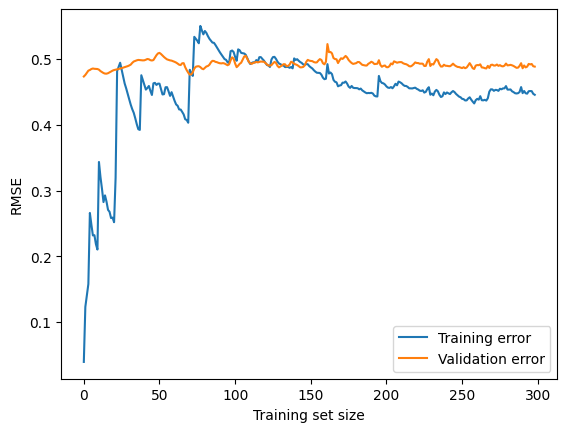

In [81]:
plot_learning_curves(model,X_train,y_train,X_val,y_val)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


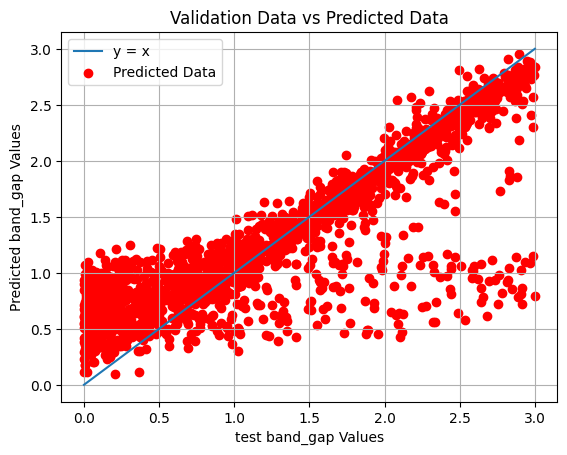

In [82]:
y_pred = model.predict(X_test)
x = np.linspace(0, 3, 100)
y = x
# Create the plot
plt.plot(x, y, label='y = x')

plt.scatter(y_test, y_pred, color='red', label='Predicted Data')
plt.xlabel('test band_gap Values')
plt.ylabel('Predicted band_gap Values')
plt.title('Validation Data vs Predicted Data')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig("result")

In [83]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.7217799685980635

"plt.plot(history.history['mae'], label='Train MAE')\nplt.plot(history.history['val_mae'], label='Validation MAE')\nplt.title('Model MAE')\nplt.ylabel('Mean Absolute Error')\nplt.xlabel('Epoch')\nplt.legend(loc='upper right')\n\nplt.tight_layout()\nplt.show()"

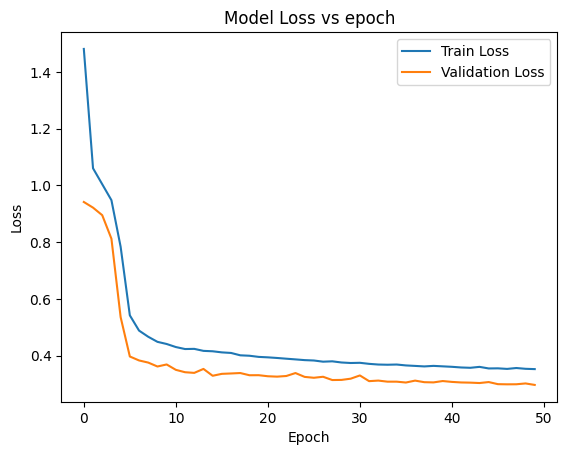

In [88]:
import matplotlib.pyplot as plt

# Plotting the loss

# Plot training & validation loss values
#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig("loss")
# Plot training & validation MAE values
#plt.subplot(1, 2, 2)
'''plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()'''

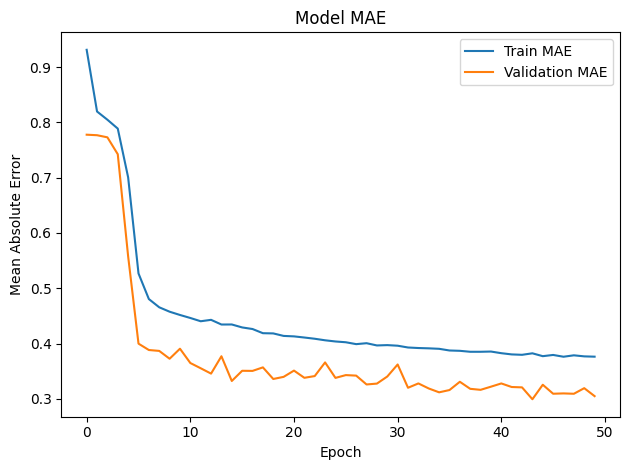

In [89]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# For neural network

In [90]:
X = df.drop(columns=['band_gap'])
y = df['band_gap']

#X_train, useless_x, y_train, useless_y = train_test_split(X, y, test_size=1, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [92]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    layers.Dropout(0.2),  # Dropout layer for regularization
    layers.Dense(128, activation='relu'),  # Second hidden layer
    layers.Dropout(0.2),  # Another dropout layer
    layers.Dense(64, activation='relu'),  # Third hidden layer
    layers.Dense(32, activation='relu'),  # Fourth hidden layer
    layers.Dense(1)  # Output layer for regression
])
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])

/Users/tik/anaconda3/envs/david/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=24)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 0.7613 - mae: 0.6528 - val_loss: 0.2284 - val_mae: 0.3141
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.2704 - mae: 0.3692 - val_loss: 0.2013 - val_mae: 0.2890
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.2636 - mae: 0.3546 - val_loss: 0.1966 - val_mae: 0.2802
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.2395 - mae: 0.3341 - val_loss: 0.1933 - val_mae: 0.2706
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 0.2334 - mae: 0.3246 - val_loss: 0.1860 - val_mae: 0.2592
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.2265 - mae: 0.3091 - val_loss: 0.1969 - val_mae: 0.2896
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.2170 - mae: 0.2956 - val_loss: 0.1914 - val_mae: 0.2913
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.1978 - mae: 0.2816 - val_loss: 0.1842 - val_mae: 0.2702
Epoch 9/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5632e-04 - mae: 0.0160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - mae: 0.0358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2757e-04 - mae: 0.0241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - mae: 0.0630
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080 - mae: 0.0731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - mae: 0.0819
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132 - mae: 0.1009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

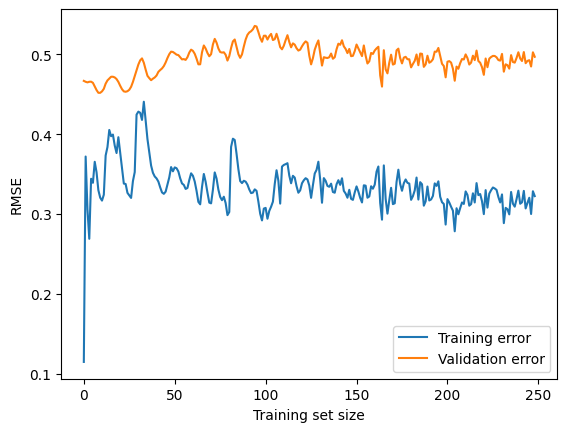

In [94]:
from sklearn.metrics import mean_squared_error
import numpy as np
def plot_learning_curves(model,X_train,y_train,X_val,y_val):
    mse_train_list,mse_val_list = [],[]
    mtrain = X_train.shape[0]
    for m in range(1,250):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        mse_train = mean_squared_error(y_train[:m],y_train_predict)
        mse_val = mean_squared_error(y_val,y_val_predict)    
        mse_train_list.append(mse_train)
        mse_val_list.append(mse_val)
    plt.plot(np.sqrt(mse_train_list),label='Training error')
    plt.plot(np.sqrt(mse_val_list),label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend()
    #plt.ylim(0,0.4)
    plt.show()
    #plt.savefig("figure")
plot_learning_curves(model,X_train,y_train,X_val,y_val)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


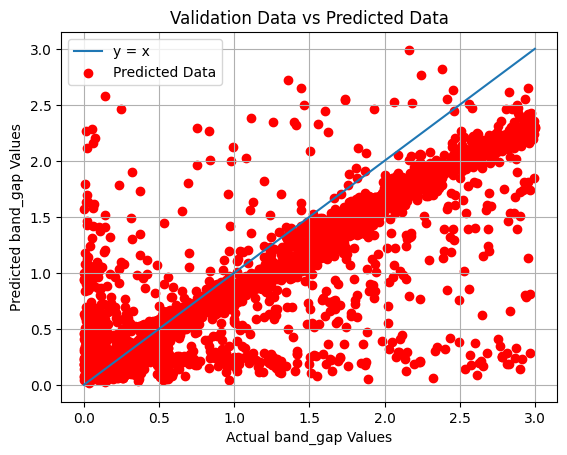

In [95]:
y_pred = model.predict(X_test)
x = np.linspace(0, 3, 100)
y = x
# Create the plot
plt.plot(x, y, label='y = x')

plt.scatter(y_test, y_pred, color='red', label='Predicted Data')
plt.xlabel('Actual band_gap Values')
plt.ylabel('Predicted band_gap Values')
plt.title('Validation Data vs Predicted Data')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig("result")

In [96]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.6641972931054121

# For CGCNN

In [109]:
import csv
import matplotlib.pyplot as plt
# Initialize lists to store the columns
target = []
predicted = []

# Read the CSV file
with open('test_results.csv', 'r') as file:
    csv_reader = csv.reader(file)
    
    # Extract the 2nd and 3rd columns (index 1 and 2)
    for row in csv_reader:
        target.append(float(row[1]))  # Convert to float
        predicted.append(float(row[2]))   # Convert to float


In [110]:
from sklearn.metrics import r2_score
r2 = r2_score(target, predicted)
r2

0.5048594602906386

In [118]:
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(target,predicted)
print(rmse)

0.41500884892169476


In [119]:
from sklearn.metrics import mean_absolute_error
rmae = mean_absolute_error(target,predicted)
print(rmae)

0.47598475471736307


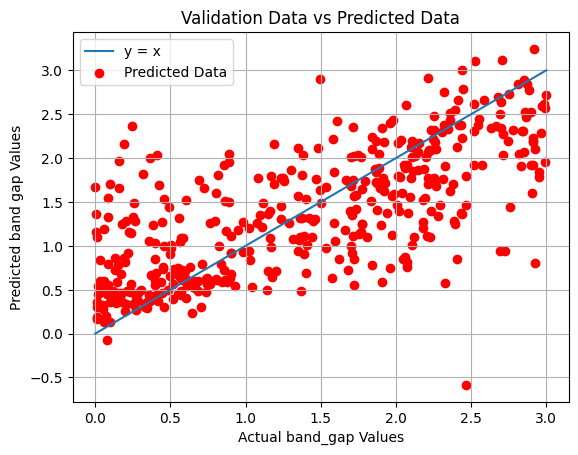

In [117]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 3, 100)
y = x
# Create the plot
plt.plot(x, y, label='y = x')

plt.scatter(target, predicted, color='red', label='Predicted Data')
plt.xlabel('Actual band_gap Values')
plt.ylabel('Predicted band gap Values')
plt.title('Validation Data vs Predicted Data')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig("result_cgcnn")

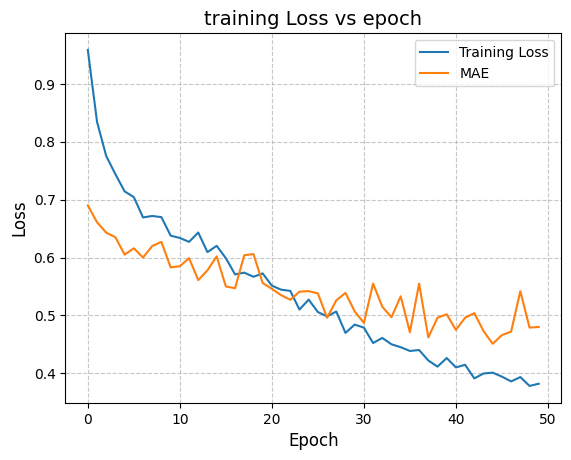

In [116]:
import matplotlib.pyplot as plt
import re

# Initialize lists to store epochs and losses
epochs = []
losses = []

# Read the log file
with open('output.txt', 'r') as file:
    for line in file:
        # Match lines like "Epoch: [X][Y/60] ... Loss A (B) ..."
        if "Epoch: [" in line and "Loss" in line:
            # Extract epoch number (first number in brackets)
            epoch_match = re.search(r'Epoch: \[(\d+)\]', line)
            if epoch_match:
                epoch = int(epoch_match.group(1))
                
                # Extract the "Loss A (B)" value (we want B, the running average)
                loss_match = re.search(r'Loss \d+\.\d+ \((\d+\.\d+)\)', line)
                if loss_match:
                    loss = float(loss_match.group(1))
                    
                    # Only record the last loss entry per epoch (50/60)
                    if "[330/338]" in line:
                        epochs.append(epoch)
                        losses.append(loss)

# Plotting
#plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Training Loss')
epochs = list(range(50))  # Replace with actual epochs
import numpy as np

# Load the MAE values from the text file
mae_values = np.loadtxt('MAE.txt', dtype=float)

# Display the loaded values
#print(mae_values)
plt.plot(epochs, mae_values,label='MAE')
plt.title('training Loss vs epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
#plt.savefig("loss_cgcnn")
plt.show()

# Linear regression

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.DataFrame(data)
df = df.dropna()
X = df.drop(columns=['band_gap'])
y = df['band_gap']

#X_train, useless_x, y_train, useless_y = train_test_split(X, y, test_size=1, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

In [105]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

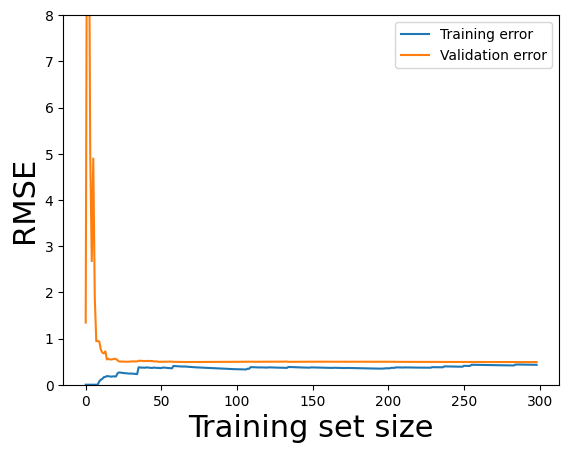

In [106]:
from sklearn.metrics import mean_squared_error
def plot_learning_curves(model,X_train,y_train,X_val,y_val):
    mse_train_list,mse_val_list = [],[]
    mtrain = X_train.shape[0]
    for m in range(1,300):
        model.fit(X_train[:m],y_train[:m])
        
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        mse_train = mean_squared_error(y_train[:m],y_train_predict)
        mse_val = mean_squared_error(y_val,y_val_predict)
    
        mse_train_list.append(mse_train)
        mse_val_list.append(mse_val)
    plt.plot(np.sqrt(mse_train_list),label='Training error')
    plt.plot(np.sqrt(mse_val_list),label='Validation error')
    plt.xlabel('Training set size',fontsize=22)
    plt.ylabel('RMSE',fontsize=22)
    plt.legend()
    plt.ylim(0,8)
    plt.show()
    
model = LinearRegression()
plot_learning_curves(model,X_train,y_train,X_val,y_val)

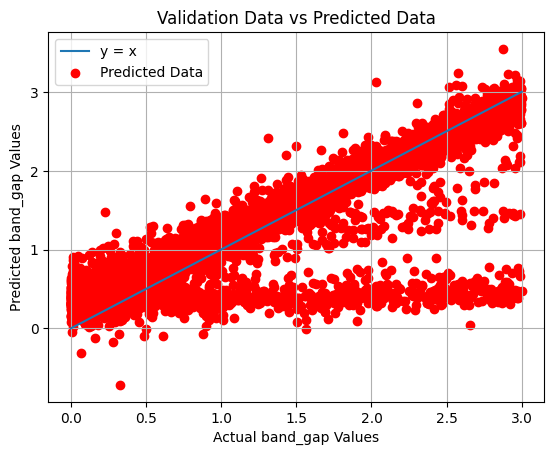

In [107]:
y_pred = model.predict(X_test)
x = np.linspace(0, 3, 100)
y = x
# Create the plot
plt.plot(x, y, label='y = x')

plt.scatter(y_test, y_pred, color='red', label='Predicted Data')
plt.xlabel('Actual band_gap Values')
plt.ylabel('Predicted band_gap Values')
plt.title('Validation Data vs Predicted Data')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig("result")

In [108]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.6799667719097904